In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import warnings
warnings.filterwarnings("ignore")


# **Data preprocessing**

In [155]:
data = pd.read_csv(r"C:\Users\USER\Downloads\archive\train.csv")

In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [157]:
def drop_columns(df):
    df.drop(['ID','Delivery_person_ID'],axis=1,inplace=True)
drop_columns(data)


In [158]:
if (len(data[data.duplicated()])>0):
    print("There are Duplicate values present")
else:
    print("There is no duplicate value present")

There is no duplicate value present


In [159]:
#Update datatypes
def update_datatype(df):
    df['Delivery_person_Age'] = df['Delivery_person_Age'].astype('float64')
    df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].astype('float64')
    df['multiple_deliveries'] = df['multiple_deliveries'].astype('float64')
    df['Order_Date']=pd.to_datetime(df['Order_Date'],format="%d-%m-%Y")
update_datatype(data)

In [160]:

data.replace('NaN', float(np.nan), regex=True,inplace=True)
data.isna().sum().sort_values(ascending = False)


Delivery_person_Ratings        1908
Delivery_person_Age            1854
Time_Orderd                    1731
City                           1200
multiple_deliveries             993
Weatherconditions               616
Road_traffic_density            601
Festival                        228
Order_Date                        0
Delivery_location_longitude       0
Time_Order_picked                 0
Delivery_location_latitude        0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
Restaurant_longitude              0
Restaurant_latitude               0
Time_taken(min)                   0
dtype: int64

In [161]:
data['Weatherconditions']=data['Weatherconditions'].str.split(" ", expand=True)[1]
data['Time_taken(min)']=data['Time_taken(min)'].str.split(" ", expand=True)[1]

In [162]:
data['Time_taken(min)'] = data['Time_taken(min)'].astype(int)


In [163]:
def drop_missing_values(df):
    # Drop rows where any of the specified columns have missing values
    columns_to_check = ['Delivery_person_Age', 'Weatherconditions', 'City', 
                        'Festival', 'multiple_deliveries', 'Road_traffic_density', 
                        'Delivery_person_Ratings']
    df.dropna(subset=columns_to_check, inplace=True)

# Example usage
drop_missing_values(data)
print(data.isnull().sum())


Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Order_Date                     0
Time_Orderd                    0
Time_Order_picked              0
Weatherconditions              0
Road_traffic_density           0
Vehicle_condition              0
Type_of_order                  0
Type_of_vehicle                0
multiple_deliveries            0
Festival                       0
City                           0
Time_taken(min)                0
dtype: int64


Feature Engineering

In [164]:
import pandas as pd
import numpy as np

def calculate_time_diff(df):
    # Convert times to timedelta objects
    df['Time_Ordered'] = pd.to_timedelta(df['Time_Orderd'])
    df['Time_Order_Picked'] = pd.to_timedelta(df['Time_Order_picked'])

    # Convert dates to datetime format
    df['Order_Date'] = pd.to_datetime(df['Order_Date'])

    # Calculate datetime for ordered and picked times
    # This approach ensures the date and time are combined correctly
    df['Time_Ordered_Formatted'] = df['Order_Date'] + df['Time_Ordered']
    df['Time_Order_Picked_Formatted'] = df['Order_Date'] + df['Time_Order_Picked']

    # Adjust for next day if time picked is earlier in the day than time ordered
    mask = df['Time_Order_Picked'] < df['Time_Ordered']
    df.loc[mask, 'Time_Order_Picked_Formatted'] += pd.Timedelta(days=1)

    # Calculate preparation time in minutes
    df['order_prepare_time'] = (df['Time_Order_Picked_Formatted'] - df['Time_Ordered_Formatted']).dt.total_seconds() / 60

    # Handle null values by filling with the median
    df['order_prepare_time'].fillna(df['order_prepare_time'].median(), inplace=True)


calculate_time_diff(data)
data.head()


,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,...,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Time_Ordered,Time_Order_Picked,Time_Ordered_Formatted,Time_Order_Picked_Formatted,order_prepare_time
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,...,motorcycle,0.0,No,Urban,24,0 days 11:30:00,0 days 11:45:00,2022-03-19 11:30:00,2022-03-19 11:45:00,15.0
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,...,scooter,1.0,No,Metropolitian,33,0 days 19:45:00,0 days 19:50:00,2022-03-25 19:45:00,2022-03-25 19:50:00,5.0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,...,motorcycle,1.0,No,Urban,26,0 days 08:30:00,0 days 08:45:00,2022-03-19 08:30:00,2022-03-19 08:45:00,15.0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,...,motorcycle,1.0,No,Metropolitian,21,0 days 18:00:00,0 days 18:10:00,2022-04-05 18:00:00,2022-04-05 18:10:00,10.0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,...,scooter,1.0,No,Metropolitian,30,0 days 13:30:00,0 days 13:45:00,2022-03-26 13:30:00,2022-03-26 13:45:00,15.0


In [146]:
!pip install geopy

In [147]:
from geopy.distance import geodesic

In [165]:
def calculate_distance(df):
    df['distance']=np.zeros(len(df))
    restaurant_coordinates=df[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
    delivery_location_coordinates=df[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()
    df['distance'] = np.array([geodesic(restaurant, delivery) for restaurant, delivery in zip(restaurant_coordinates, delivery_location_coordinates)])
    df['distance']= df['distance'].astype("str").str.extract('(\d+)').astype("int64")

calculate_distance(data)
data.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,...,multiple_deliveries,Festival,City,Time_taken(min),Time_Ordered,Time_Order_Picked,Time_Ordered_Formatted,Time_Order_Picked_Formatted,order_prepare_time,distance
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,...,0.0,No,Urban,24,0 days 11:30:00,0 days 11:45:00,2022-03-19 11:30:00,2022-03-19 11:45:00,15.0,3
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,...,1.0,No,Metropolitian,33,0 days 19:45:00,0 days 19:50:00,2022-03-25 19:45:00,2022-03-25 19:50:00,5.0,20
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,...,1.0,No,Urban,26,0 days 08:30:00,0 days 08:45:00,2022-03-19 08:30:00,2022-03-19 08:45:00,15.0,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,...,1.0,No,Metropolitian,21,0 days 18:00:00,0 days 18:10:00,2022-04-05 18:00:00,2022-04-05 18:10:00,10.0,7
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,...,1.0,No,Metropolitian,30,0 days 13:30:00,0 days 13:45:00,2022-03-26 13:30:00,2022-03-26 13:45:00,15.0,6


In [166]:
# Assume 'data' is your DataFrame and 'distance' is the column from which you want to remove outliers
Q1 = data['distance'].quantile(0.25)
Q3 = data['distance'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers = data[(data['distance'] < lower_bound) | (data['distance'] > upper_bound)]
outlier_count = outliers.shape[0]
print(f"Number of outliers: {outlier_count}")

# Remove outliers
data_clean = data[(data['distance'] >= lower_bound) & (data['distance'] <= upper_bound)]

# Optionally, you can verify the new size of the data
print(f"Number of data points after outlier removal: {data_clean.shape[0]}")


Number of outliers: 146
Number of data points after outlier removal: 41222


In [167]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41222 entries, 0 to 45592
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype          
---  ------                       --------------  -----          
 0   Delivery_person_Age          41222 non-null  float64        
 1   Delivery_person_Ratings      41222 non-null  float64        
 2   Restaurant_latitude          41222 non-null  float64        
 3   Restaurant_longitude         41222 non-null  float64        
 4   Delivery_location_latitude   41222 non-null  float64        
 5   Delivery_location_longitude  41222 non-null  float64        
 6   Order_Date                   41222 non-null  datetime64[ns] 
 7   Time_Orderd                  41222 non-null  object         
 8   Time_Order_picked            41222 non-null  object         
 9   Weatherconditions            41222 non-null  object         
 10  Road_traffic_density         41222 non-null  object         
 11  Vehicle_condition            4122

In [168]:
def drop_columns(df):
    df.drop(['Order_Date','Time_Orderd','Time_Ordered','Time_Order_Picked','Time_Order_picked','Time_Ordered_Formatted',
             'Time_Order_Picked_Formatted','Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude'],axis=1,inplace=True)
drop_columns(data_clean)

data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41222 entries, 0 to 45592
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Delivery_person_Age      41222 non-null  float64
 1   Delivery_person_Ratings  41222 non-null  float64
 2   Weatherconditions        41222 non-null  object 
 3   Road_traffic_density     41222 non-null  object 
 4   Vehicle_condition        41222 non-null  int64  
 5   Type_of_order            41222 non-null  object 
 6   Type_of_vehicle          41222 non-null  object 
 7   multiple_deliveries      41222 non-null  float64
 8   Festival                 41222 non-null  object 
 9   City                     41222 non-null  object 
 10  Time_taken(min)          41222 non-null  int32  
 11  order_prepare_time       41222 non-null  float64
 12  distance                 41222 non-null  int64  
dtypes: float64(4), int32(1), int64(2), object(6)
memory usage: 4.2+ MB


In [101]:
data = data_clean

In [102]:
def label_encoding(df):
    categorical_columns = df.select_dtypes(include='object').columns
    label_encoder = LabelEncoder()
    df[categorical_columns] = df[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))

label_encoding(data)

In [103]:
X = data.drop('Time_taken(min)', axis=1)  # Features
y = data['Time_taken(min)']  # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [105]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred_test = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

# Function to calculate Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculating metrics for the test dataset
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Calculating metrics for the train dataset
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Print the metrics
print("Test Data Metrics:")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_test}%")
print(f"R-squared: {r2_test}")

print("\nTrain Data Metrics:")
print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Root Mean Squared Error (RMSE): {rmse_train}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_train}%")
print(f"R-squared: {r2_train}")


Test Data Metrics:
Mean Squared Error (MSE): 42.95751943605036
Root Mean Squared Error (RMSE): 6.554198611275856
Mean Absolute Percentage Error (MAPE): 23.22891096951999%
R-squared: 0.5054197286149282

Train Data Metrics:
Mean Squared Error (MSE): 43.36610597411972
Root Mean Squared Error (RMSE): 6.585294676331479
Mean Absolute Percentage Error (MAPE): 23.01024711268001%
R-squared: 0.5029529201067253


In [106]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [145]:
param_grid = {
    'alpha': np.logspace(-4, -0.5, 30)  # Adjust range based on your specific needs
}

lasso = Lasso(max_iter=10000, tol=0.01)  # Increase max_iter and adjust tol if convergence issues occur
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=Lasso(max_iter=10000, tol=0.01),
             param_grid={'alpha': array([1.00000000e-04, 1.32035178e-04, 1.74332882e-04, 2.30180731e-04,
       3.03919538e-04, 4.01280703e-04, 5.29831691e-04, 6.99564216e-04,
       9.23670857e-04, 1.21957046e-03, 1.61026203e-03, 2.12611233e-03,
       2.80721620e-03, 3.70651291e-03, 4.89390092e-03, 6.46167079e-03,
       8.53167852e-03, 1.12648169e-02, 1.48735211e-02, 1.96382800e-02,
       2.59294380e-02, 3.42359796e-02, 4.52035366e-02, 5.96845700e-02,
       7.88046282e-02, 1.04049831e-01, 1.37382380e-01, 1.81393069e-01,
       2.39502662e-01, 3.16227766e-01])},
             scoring='neg_mean_squared_error', verbose=1)

In [146]:
best_lasso = grid_search.best_estimator_

# Predict on the training and test data
y_train_pred = best_lasso.predict(X_train)
y_test_pred = best_lasso.predict(X_test)

# Calculate metrics for training data
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
r2_train = r2_score(y_train, y_train_pred)

# Calculate metrics for test data
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
r2_test = r2_score(y_test, y_test_pred)

# Print out the best alpha parameter and all metrics
print("Best alpha parameter: ", grid_search.best_params_)
print("Training Metrics:")
print("MSE: {:.4f}".format(mse_train))
print("RMSE: {:.4f}".format(rmse_train))
print("MAPE: {:.2f}%".format(mape_train))
print("R²: {:.4f}".format(r2_train))

print("Test Metrics:")
print("MSE: {:.4f}".format(mse_test))
print("RMSE: {:.4f}".format(rmse_test))
print("MAPE: {:.2f}%".format(mape_test))
print("R²: {:.4f}".format(r2_test))

Best alpha parameter:  {'alpha': 0.0009236708571873865}
Training Metrics:
MSE: 35.2337
RMSE: 5.9358
MAPE: 20.68%
R²: 0.5962
Test Metrics:
MSE: 34.3797
RMSE: 5.8634
MAPE: 20.54%
R²: 0.6042


In [96]:
!pip install optuna

In [107]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
# Define the objective function for optimization
def objective(trial):
    params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_loguniform('eta', 0.01, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        "learning_rate":trial.suggest_loguniform("learning_rate",0.05,0.7)
    }

    # Initialize and train the XGBoost regressor with suggested parameters
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)

    # Predict and calculate RMSE
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    return rmse

# Create the Optuna study and run optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-04-17 09:52:34,194] A new study created in memory with name: no-name-61916531-2dab-4c17-9fea-a3a3aee554bd
[I 2024-04-17 09:52:34,950] Trial 0 finished with value: 3.7178733921216365 and parameters: {'lambda': 0.00039581588971551723, 'alpha': 8.234193580561484e-06, 'max_depth': 9, 'eta': 0.012465490752955246, 'subsample': 0.6456685316900741, 'colsample_bytree': 0.9529448985916233, 'min_child_weight': 91, 'learning_rate': 0.31229976418167044}. Best is trial 0 with value: 3.7178733921216365.
[I 2024-04-17 09:52:35,700] Trial 1 finished with value: 3.9184775726094907 and parameters: {'lambda': 5.460965117908962e-08, 'alpha': 0.2416625114283886, 'max_depth': 4, 'eta': 0.03592442824654672, 'subsample': 0.7583517193633218, 'colsample_bytree': 0.9552158479972137, 'min_child_weight': 56, 'learning_rate': 0.44270558274924565}. Best is trial 0 with value: 3.7178733921216365.
[I 2024-04-17 09:52:36,378] Trial 2 finished with value: 4.322622786632976 and parameters: {'lambda': 4.52075004150

[I 2024-04-17 09:52:53,942] Trial 21 finished with value: 3.7044997137024662 and parameters: {'lambda': 0.002684806549860641, 'alpha': 1.4797051730815196e-08, 'max_depth': 8, 'eta': 0.01787283597909922, 'subsample': 0.9363176007172229, 'colsample_bytree': 0.7615530746467606, 'min_child_weight': 51, 'learning_rate': 0.15332956219381805}. Best is trial 20 with value: 3.696523356507704.
[I 2024-04-17 09:52:55,091] Trial 22 finished with value: 3.7401688469375047 and parameters: {'lambda': 0.0015161062020910671, 'alpha': 2.6022403361244238e-08, 'max_depth': 8, 'eta': 0.027229339655577552, 'subsample': 0.9387894041392761, 'colsample_bytree': 0.7424482347363943, 'min_child_weight': 46, 'learning_rate': 0.14858848777404376}. Best is trial 20 with value: 3.696523356507704.
[I 2024-04-17 09:52:56,121] Trial 23 finished with value: 3.749766088866357 and parameters: {'lambda': 0.006309610656826084, 'alpha': 1.0583049707596645e-08, 'max_depth': 7, 'eta': 0.017126911076766498, 'subsample': 0.943598

[I 2024-04-17 09:53:18,461] Trial 43 finished with value: 3.7816786609960586 and parameters: {'lambda': 0.24888669830685797, 'alpha': 2.4735584358697855e-07, 'max_depth': 8, 'eta': 0.02257624239157886, 'subsample': 0.9726544296681957, 'colsample_bytree': 0.7469680713601199, 'min_child_weight': 212, 'learning_rate': 0.1228092823465617}. Best is trial 25 with value: 3.6895963053284815.
[I 2024-04-17 09:53:19,594] Trial 44 finished with value: 3.72603117302977 and parameters: {'lambda': 3.626103724365476e-05, 'alpha': 2.8705250975816196e-06, 'max_depth': 9, 'eta': 0.011601337437459811, 'subsample': 0.9191933189197966, 'colsample_bytree': 0.8508740222254296, 'min_child_weight': 150, 'learning_rate': 0.17475892894836026}. Best is trial 25 with value: 3.6895963053284815.
[I 2024-04-17 09:53:20,838] Trial 45 finished with value: 3.686633479160015 and parameters: {'lambda': 0.007803376620271596, 'alpha': 2.9214977252335294e-08, 'max_depth': 8, 'eta': 0.013999839214367968, 'subsample': 0.871324

[I 2024-04-17 09:53:42,308] Trial 65 finished with value: 3.715616400357241 and parameters: {'lambda': 0.5987899151832938, 'alpha': 0.001211407553237578, 'max_depth': 7, 'eta': 0.0866482899592701, 'subsample': 0.6011164110889028, 'colsample_bytree': 0.9594392005181254, 'min_child_weight': 49, 'learning_rate': 0.07030720119389255}. Best is trial 58 with value: 3.671769556550455.
[I 2024-04-17 09:53:43,416] Trial 66 finished with value: 3.697006989312797 and parameters: {'lambda': 0.049411008365825335, 'alpha': 0.0054506694205453746, 'max_depth': 7, 'eta': 0.011925213332343592, 'subsample': 0.885503793091743, 'colsample_bytree': 0.9096450202674441, 'min_child_weight': 23, 'learning_rate': 0.06089087799131906}. Best is trial 58 with value: 3.671769556550455.
[I 2024-04-17 09:53:44,424] Trial 67 finished with value: 3.7613673350186145 and parameters: {'lambda': 0.265860881188081, 'alpha': 0.0320239495787779, 'max_depth': 6, 'eta': 0.010221557999054416, 'subsample': 0.7315801357878227, 'col

[I 2024-04-17 09:54:07,171] Trial 87 finished with value: 3.7091701836874904 and parameters: {'lambda': 0.36501620748954133, 'alpha': 7.650773394743506e-05, 'max_depth': 8, 'eta': 0.013727764739634352, 'subsample': 0.8882253993058997, 'colsample_bytree': 0.940211342879364, 'min_child_weight': 35, 'learning_rate': 0.5199590934198944}. Best is trial 74 with value: 3.6652188575513946.
[I 2024-04-17 09:54:08,388] Trial 88 finished with value: 3.665771424016177 and parameters: {'lambda': 0.0122127611202247, 'alpha': 0.0018697324476791633, 'max_depth': 8, 'eta': 0.011171058022795948, 'subsample': 0.938390108775928, 'colsample_bytree': 0.9657785191726237, 'min_child_weight': 51, 'learning_rate': 0.062880366910342}. Best is trial 74 with value: 3.6652188575513946.
[I 2024-04-17 09:54:09,588] Trial 89 finished with value: 3.6651080234763898 and parameters: {'lambda': 0.10621327891386552, 'alpha': 0.0014491608508622558, 'max_depth': 8, 'eta': 0.0112343520715266, 'subsample': 0.9631181261939504, 

In [108]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 100
Best trial: {'lambda': 0.10621327891386552, 'alpha': 0.0014491608508622558, 'max_depth': 8, 'eta': 0.0112343520715266, 'subsample': 0.9631181261939504, 'colsample_bytree': 0.9722870094720807, 'min_child_weight': 49, 'learning_rate': 0.06160117720300807}


In [109]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Print best parameters
print("Best parameters:", study.best_trial.params)

# Evaluate the best model
best_params = study.best_trial.params
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)

# Calculate MSE, RMSE, MAPE, and R-squared for the training set
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
train_mape = mean_absolute_percentage_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

# Calculate MSE, RMSE, MAPE, and R-squared for the testing set
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Print the results for both training and testing set
print("Training MSE: ", train_mse)
print("Training RMSE: ", train_rmse)
print("Training MAPE: ", train_mape)
print("Training R^2: ", train_r2)

print("Testing MSE: ", test_mse)
print("Testing RMSE: ", test_rmse)
print("Testing MAPE: ", test_mape)
print("Testing R^2: ", test_r2)

Best parameters: {'lambda': 0.10621327891386552, 'alpha': 0.0014491608508622558, 'max_depth': 8, 'eta': 0.0112343520715266, 'subsample': 0.9631181261939504, 'colsample_bytree': 0.9722870094720807, 'min_child_weight': 49, 'learning_rate': 0.06160117720300807}
Training MSE:  11.973538617419623
Training RMSE:  3.4602801356854944
Training MAPE:  0.1197373879949895
Training R^2:  0.8627635045367112
Testing MSE:  13.433016823751009
Testing RMSE:  3.6651080234763898
Testing MAPE:  0.12645538530609082
Testing R^2:  0.8453424407780039


In [110]:
#XGB vip

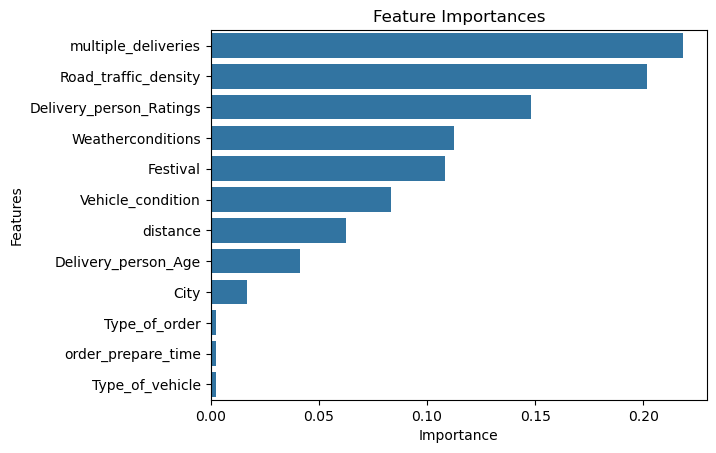

In [112]:
importances = best_model.feature_importances_

# Create a Series with feature names and importances
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

import seaborn as sns

sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


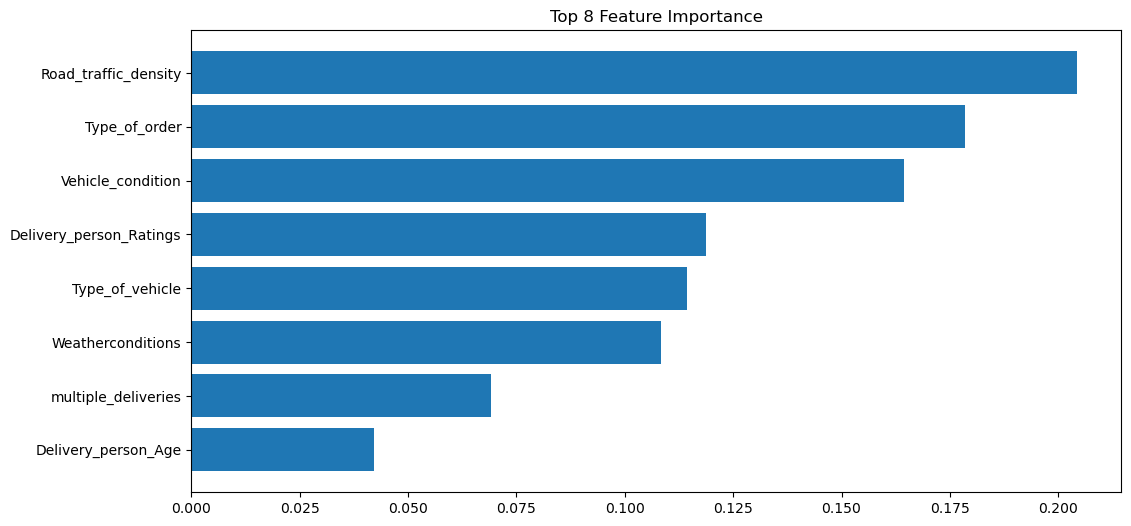

In [131]:
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-8:]  # Slice to get only the top 10 features

fig, ax = plt.subplots(figsize=(12, 6))

ax.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
ax.set_yticks(range(len(sorted_idx)))
ax.set_yticklabels(np.array(X_test.columns)[sorted_idx])

ax.set_title('Top 8 Feature Importance')
plt.show()


In [121]:
threshold = 0.04 # Adjust this value based on your needs
important_features = X_train.columns[importances > threshold]
important_features

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Weatherconditions',
       'Road_traffic_density', 'Vehicle_condition', 'multiple_deliveries',
       'Festival', 'distance'],
      dtype='object')

In [126]:
threshold = 0.04 # Adjust this value based on your needs
important_features = X_train.columns[importances > threshold]

# Reduce X_train and X_test to important features only
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

best_params = study.best_trial.params
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train_important, y_train)

XGBRegressor(alpha=0.0014491608508622558, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9722870094720807, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.0112343520715266, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.10621327891386552,
             learning_rate=0.06160117720300807, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=49, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, ...)

In [127]:
train_predictions = best_model.predict(X_train_important)
test_predictions = best_model.predict(X_test_important)

# Calculate MSE, RMSE, MAPE, and R-squared for the training set
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
train_mape = mean_absolute_percentage_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

# Calculate MSE, RMSE, MAPE, and R-squared for the testing set
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Print the results for both training and testing set
print("Training MSE: ", train_mse)
print("Training RMSE: ", train_rmse)
print("Training MAPE: ", train_mape)
print("Training R^2: ", train_r2)

print("Testing MSE: ", test_mse)
print("Testing RMSE: ", test_rmse)
print("Testing MAPE: ", test_mape)
print("Testing R^2: ", test_r2)

Training MSE:  12.481253552944557
Training RMSE:  3.5328817632273735
Training MAPE:  0.12275888813740483
Training R^2:  0.8569442542154702
Testing MSE:  13.578409851258204
Testing RMSE:  3.684889394711625
Testing MAPE:  0.1271474769530939
Testing R^2:  0.8436684958215439


### Partial Dependency

In [130]:
X_train_important.info()


<class 'pandas.core.frame.DataFrame'>
Index: 32977 entries, 31414 to 17401
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Delivery_person_Age      32977 non-null  float64
 1   Delivery_person_Ratings  32977 non-null  float64
 2   Weatherconditions        32977 non-null  int32  
 3   Road_traffic_density     32977 non-null  int32  
 4   Vehicle_condition        32977 non-null  int64  
 5   multiple_deliveries      32977 non-null  float64
 6   Festival                 32977 non-null  int32  
 7   distance                 32977 non-null  int64  
dtypes: float64(3), int32(3), int64(2)
memory usage: 1.9 MB


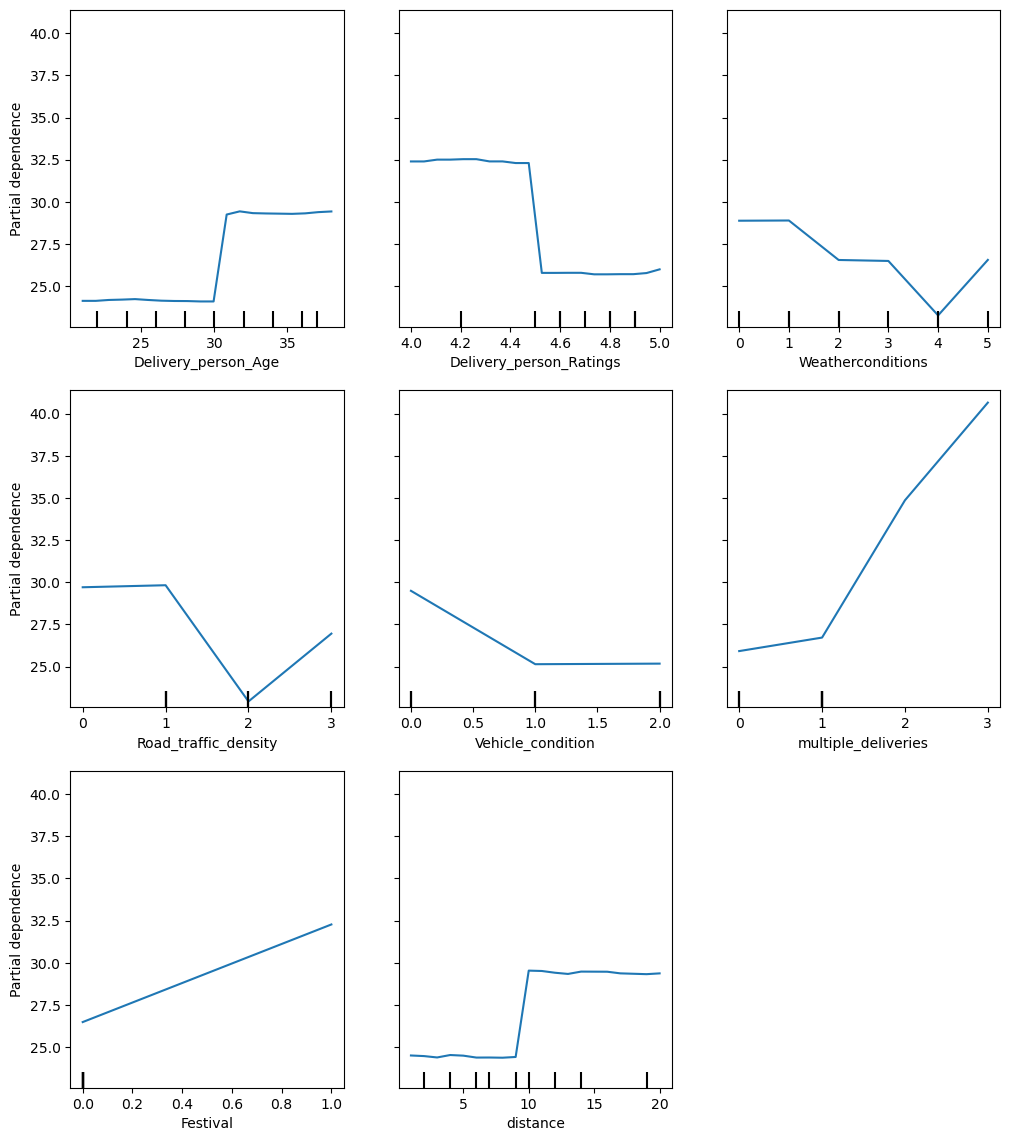

In [134]:
from sklearn.inspection import PartialDependenceDisplay

features = [0,1,2,3,4,5,6,7]  # Use integer index or feature names if available
fig, ax = plt.subplots(figsize=(12, 14))
display = PartialDependenceDisplay.from_estimator(
    best_model,
    X_train_important,
    features,
    ax=ax,
    target=y_train,
    grid_resolution=20,  # Higher resolution gives smoother curves
)
plt.show()

In [ ]:
### RANDOM FOREST

In [21]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [22]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'bootstrap': [True]
}


In [23]:
# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Setup GridSearchCV or RandomizedSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [24]:
best_rf = grid_search.best_estimator_

# Predict on the training and test data
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Calculate metrics for training data
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
r2_train = r2_score(y_train, y_train_pred)

# Calculate metrics for test data
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) if np.any(y_test) != 0 else 0
r2_test = r2_score(y_test, y_test_pred)

# Print best parameters and all calculated metrics
print("Best Parameters:", grid_search.best_params_)
print("Training Metrics:")
print("MSE: {:.4f}".format(mse_train))
print("RMSE: {:.4f}".format(rmse_train))
print("MAPE: {:.2f}%".format(mape_train))
print("R²: {:.4f}".format(r2_train))

print("Test Metrics:")
print("MSE: {:.4f}".format(mse_test))
print("RMSE: {:.4f}".format(rmse_test))
print("MAPE: {:.2f}%".format(mape_test))
print("R²: {:.4f}".format(r2_test))



Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Training Metrics:
MSE: 9.1657
RMSE: 3.0275
MAPE: 10.54%
R²: 0.8949
Test Metrics:
MSE: 14.0014
RMSE: 3.7418
MAPE: 0.13%
R²: 0.8388


In [ ]:
##### KNN

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Initialize the KNN regressor
knn = KNeighborsRegressor()

# Define the hyperparameter grid
param_grid = {
    'n_neighbors': np.arange(1, 30),  # Considering different numbers of neighbors
    'weights': ['uniform', 'distance'],  # Weight types
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
}

In [ ]:
# Setup the GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid,
                           cv=5, verbose=1, scoring='neg_mean_squared_error')

# Execute the grid search
grid_search.fit(X_train, y_train)


#### END



---



In [169]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41222 entries, 0 to 45592
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Delivery_person_Age      41222 non-null  float64
 1   Delivery_person_Ratings  41222 non-null  float64
 2   Weatherconditions        41222 non-null  object 
 3   Road_traffic_density     41222 non-null  object 
 4   Vehicle_condition        41222 non-null  int64  
 5   Type_of_order            41222 non-null  object 
 6   Type_of_vehicle          41222 non-null  object 
 7   multiple_deliveries      41222 non-null  float64
 8   Festival                 41222 non-null  object 
 9   City                     41222 non-null  object 
 10  Time_taken(min)          41222 non-null  int32  
 11  order_prepare_time       41222 non-null  float64
 12  distance                 41222 non-null  int64  
dtypes: float64(4), int32(1), int64(2), object(6)
memory usage: 4.2+ MB


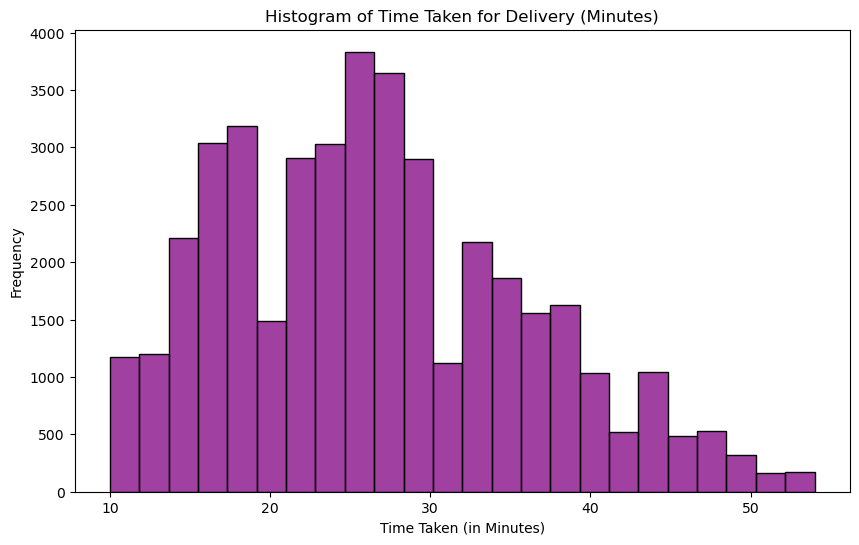

In [177]:
# Plotting the histogram with Seaborn
plt.figure(figsize=(10, 6))  # Set the figure size
sns.histplot(data_clean['Time_taken(min)'], bins=24, color='purple')
plt.title('Histogram of Time Taken for Delivery (Minutes)')
plt.xlabel('Time Taken (in Minutes)')
plt.ylabel('Frequency')
plt.show()


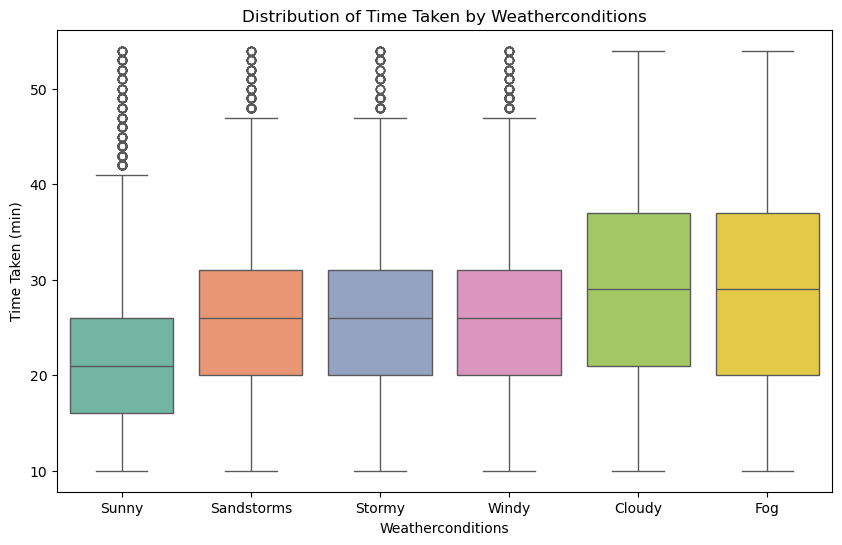

In [183]:
plt.figure(figsize=(10, 6))
# Calculate medians and sort by them
order = data.groupby('Weatherconditions')['Time_taken(min)'].median().sort_values().index.tolist()

sns.boxplot(x='Weatherconditions', y='Time_taken(min)', data=data_clean, palette = 'Set2',order=order)
plt.title('Distribution of Time Taken by Weatherconditions')
plt.xlabel('Weatherconditions')
plt.ylabel('Time Taken (min)')
plt.show()


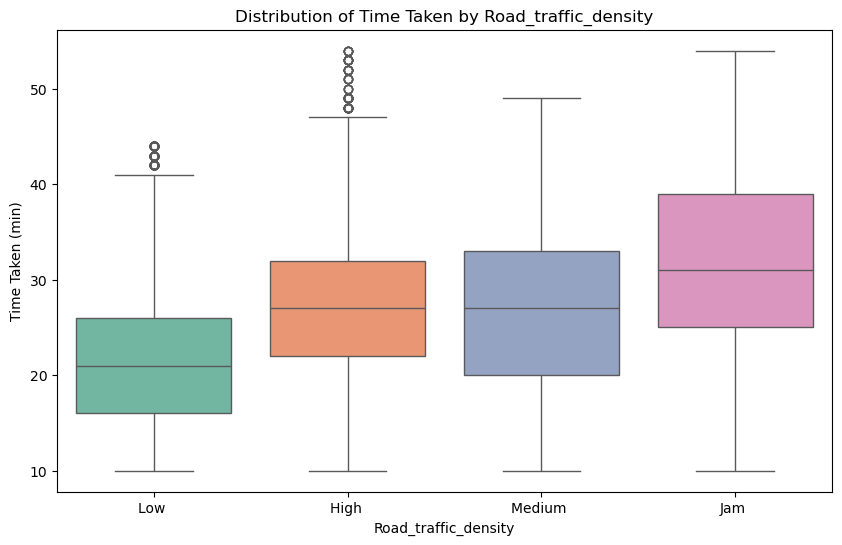

In [185]:
plt.figure(figsize=(10, 6))
order = data.groupby('Road_traffic_density')['Time_taken(min)'].median().sort_values().index.tolist()
sns.boxplot(x='Road_traffic_density', y='Time_taken(min)', data=data_clean, palette = 'Set2',order=order)
plt.title('Distribution of Time Taken by Road_traffic_density')
plt.xlabel('Road_traffic_density')
plt.ylabel('Time Taken (min)')
plt.show()

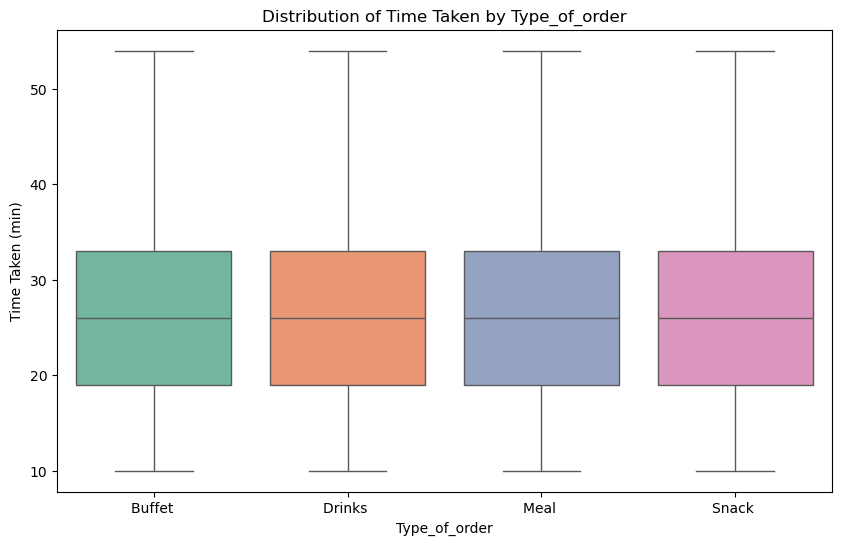

In [186]:
plt.figure(figsize=(10, 6))
order = data.groupby('Type_of_order')['Time_taken(min)'].median().sort_values().index.tolist()
sns.boxplot(x='Type_of_order', y='Time_taken(min)', data=data_clean, palette = 'Set2',order=order)
plt.title('Distribution of Time Taken by Type_of_order')
plt.xlabel('Type_of_order')
plt.ylabel('Time Taken (min)')
plt.show()

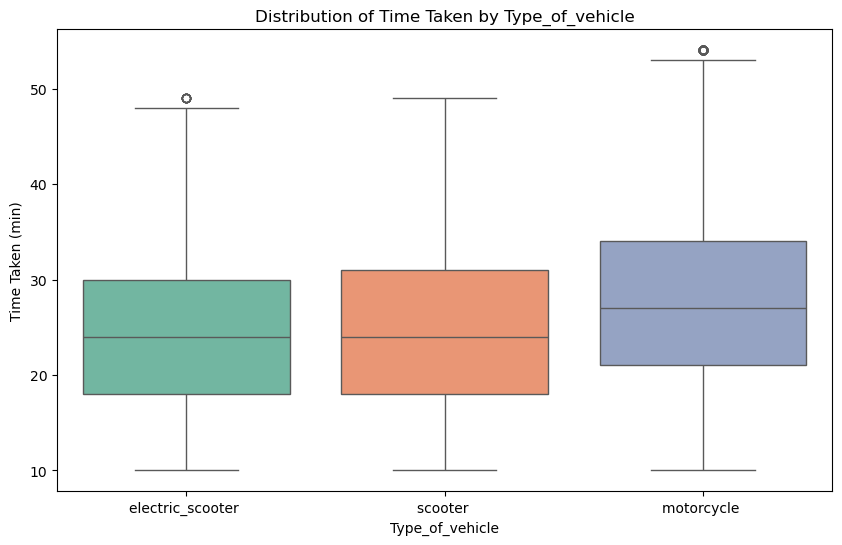

In [187]:
plt.figure(figsize=(10, 6))
order = data.groupby('Type_of_vehicle')['Time_taken(min)'].median().sort_values().index.tolist()
sns.boxplot(x='Type_of_vehicle', y='Time_taken(min)', data=data_clean, palette = 'Set2',order=order)
plt.title('Distribution of Time Taken by Type_of_vehicle')
plt.xlabel('Type_of_vehicle')
plt.ylabel('Time Taken (min)')
plt.show()

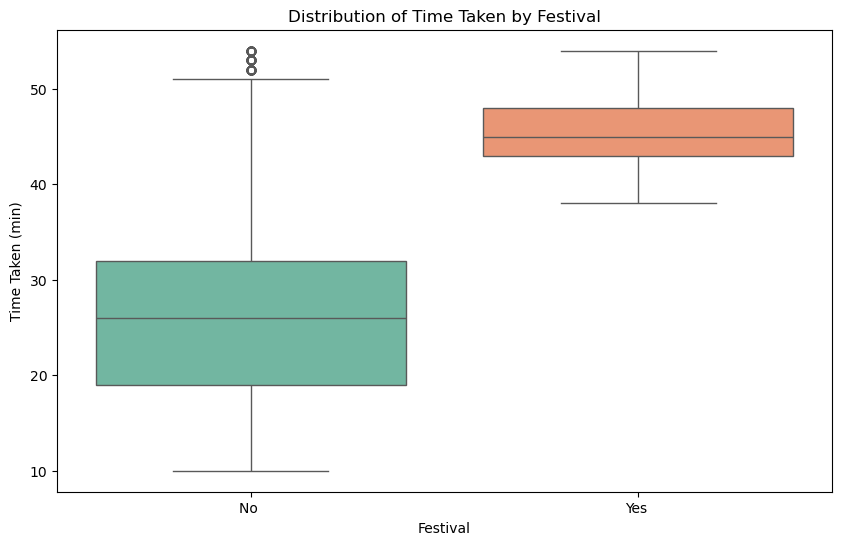

In [189]:
plt.figure(figsize=(10, 6))
order = data.groupby('Festival')['Time_taken(min)'].median().sort_values().index.tolist()
sns.boxplot(x='Festival', y='Time_taken(min)', data=data_clean, palette = 'Set2',order=order)
plt.title('Distribution of Time Taken by Festival')
plt.xlabel('Festival')
plt.ylabel('Time Taken (min)')
plt.show()

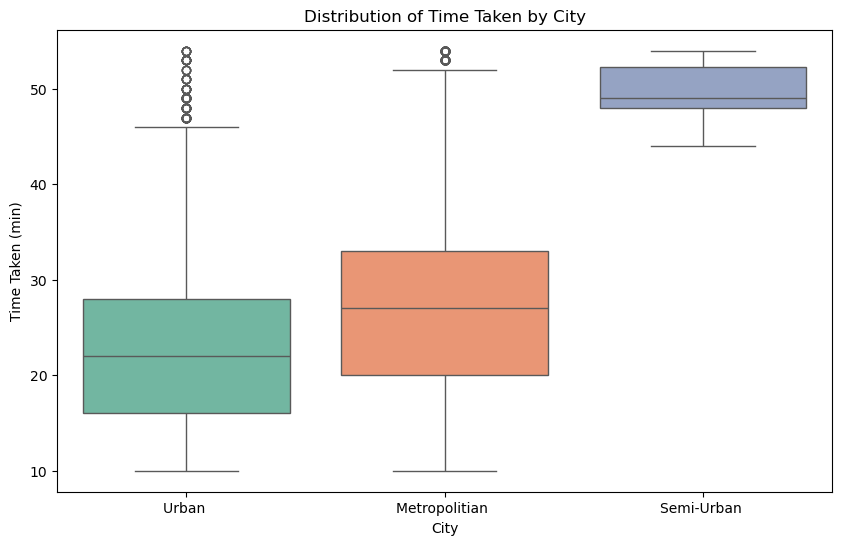

In [188]:
plt.figure(figsize=(10, 6))
order = data.groupby('City')['Time_taken(min)'].median().sort_values().index.tolist()
sns.boxplot(x='City', y='Time_taken(min)', data=data_clean, palette = 'Set2',order=order)
plt.title('Distribution of Time Taken by City')
plt.xlabel('City')
plt.ylabel('Time Taken (min)')
plt.show()

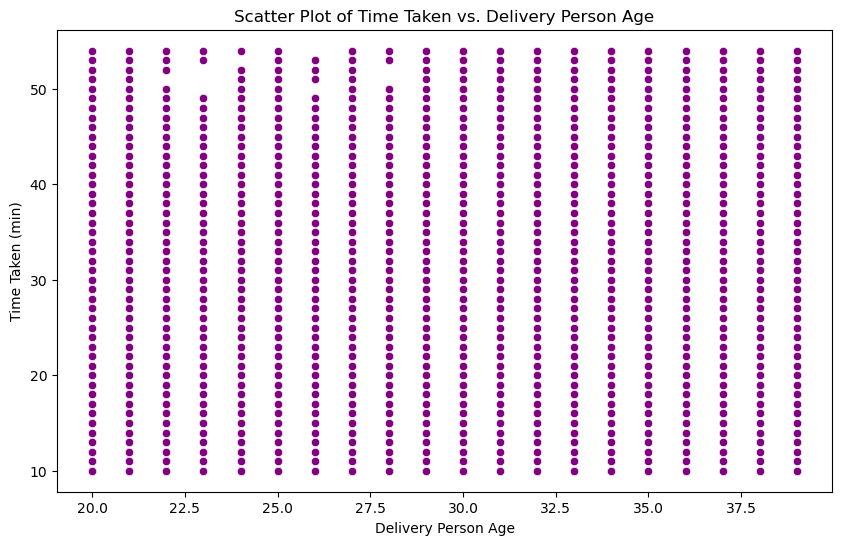

In [192]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Delivery_person_Age', y='Time_taken(min)', data=data_clean, color="purple")
plt.title('Scatter Plot of Time Taken vs. Delivery Person Age')
plt.xlabel('Delivery Person Age')
plt.ylabel('Time Taken (min)')
plt.show()

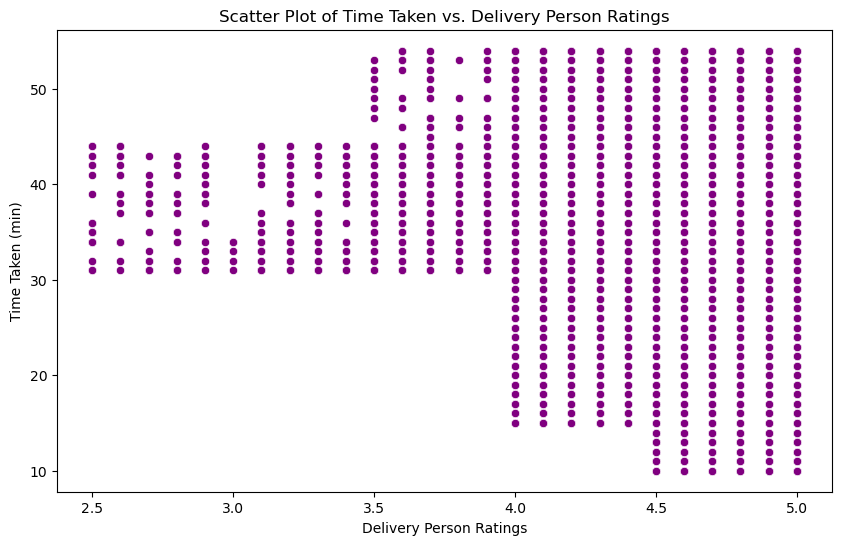

In [195]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Delivery_person_Ratings', y='Time_taken(min)', data=data_clean, color="purple")
plt.title('Scatter Plot of Time Taken vs. Delivery Person Ratings')
plt.xlabel('Delivery Person Ratings')
plt.ylabel('Time Taken (min)')
plt.show()

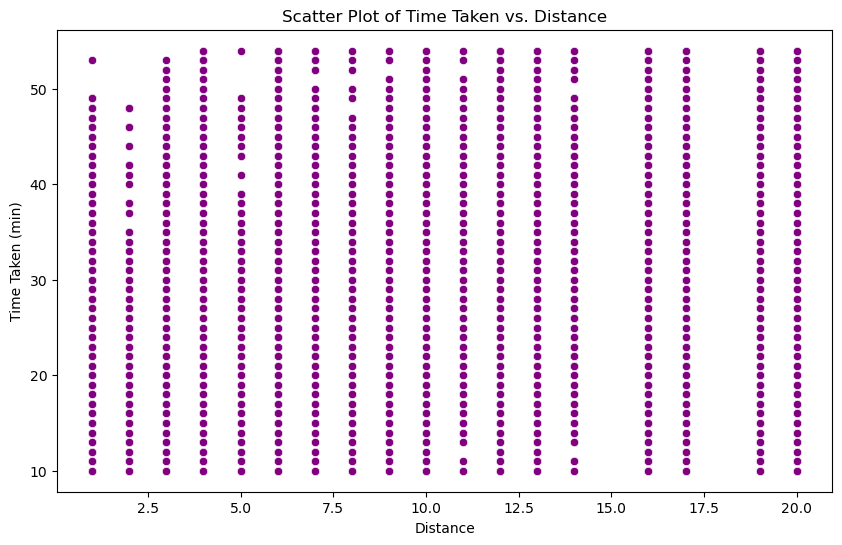

In [200]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance', y='Time_taken(min)', data=data_clean, color="purple")
plt.title('Scatter Plot of Time Taken vs. Distance')
plt.xlabel('Distance')
plt.ylabel('Time Taken (min)')
plt.show()

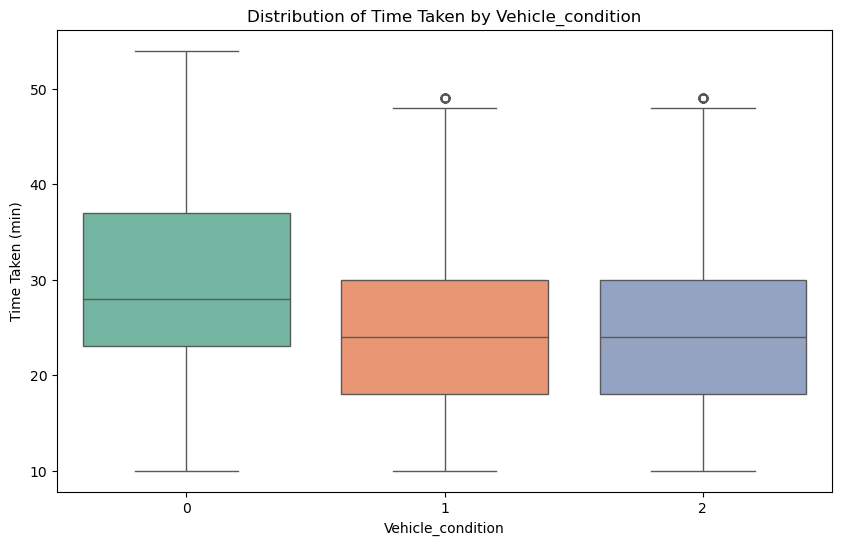

In [203]:
plt.figure(figsize=(10, 6))
#order = data.groupby('Vehicle_condition')['Time_taken(min)'].median().sort_values().index.tolist()
sns.boxplot(x='Vehicle_condition', y='Time_taken(min)', data=data_clean, palette = 'Set2')
plt.title('Distribution of Time Taken by Vehicle_condition')
plt.xlabel('Vehicle_condition')
plt.ylabel('Time Taken (min)')
plt.show()

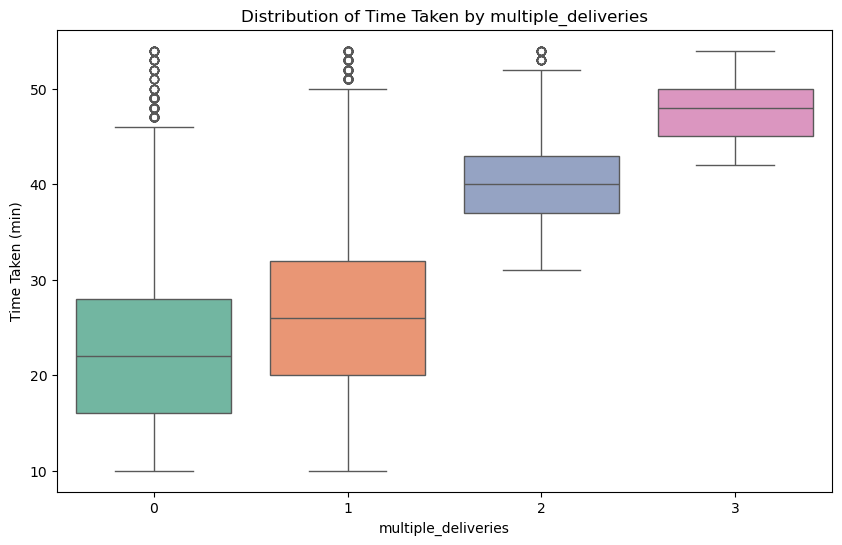

In [206]:
plt.figure(figsize=(10, 6))
#order = data.groupby('Vehicle_condition')['Time_taken(min)'].median().sort_values().index.tolist()
data_clean['multiple_deliveries'] = data_clean['multiple_deliveries'].astype('int')

sns.boxplot(x='multiple_deliveries', y='Time_taken(min)', data=data_clean, palette = 'Set2')
plt.title('Distribution of Time Taken by multiple_deliveries')
plt.xlabel('multiple_deliveries')
plt.ylabel('Time Taken (min)')
plt.show()

In [207]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41222 entries, 0 to 45592
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Delivery_person_Age      41222 non-null  float64
 1   Delivery_person_Ratings  41222 non-null  float64
 2   Weatherconditions        41222 non-null  object 
 3   Road_traffic_density     41222 non-null  object 
 4   Vehicle_condition        41222 non-null  int64  
 5   Type_of_order            41222 non-null  object 
 6   Type_of_vehicle          41222 non-null  object 
 7   multiple_deliveries      41222 non-null  int32  
 8   Festival                 41222 non-null  object 
 9   City                     41222 non-null  object 
 10  Time_taken(min)          41222 non-null  int32  
 11  order_prepare_time       41222 non-null  float64
 12  distance                 41222 non-null  int64  
dtypes: float64(3), int32(2), int64(2), object(6)
memory usage: 4.1+ MB


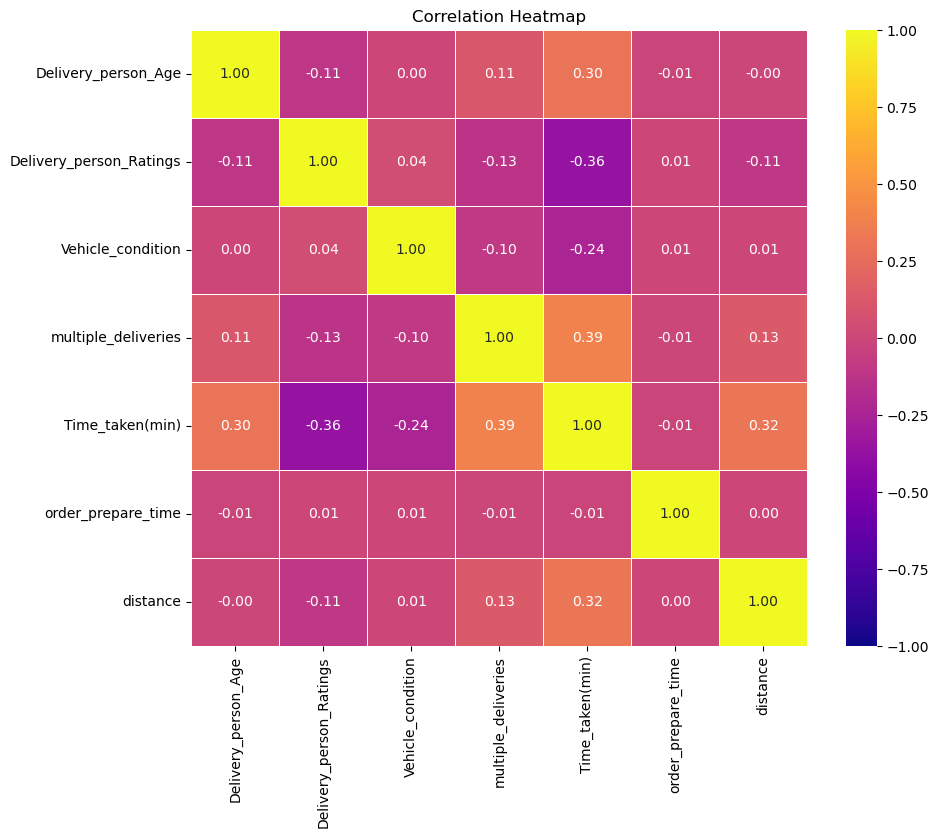

In [220]:
# Select only numeric columns
numeric_data = data_clean.select_dtypes(include=[np.number])

corr_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))  # Set the figure size for better readability
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='plasma', square=True, linewidths=.5,vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()
